## Configurando o Ambiente de Análise

In [1]:
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


pd.set_option("display.max_colwidth", None)
sns.set_theme(style="ticks", context="notebook", font_scale=1.2)
plt.rcParams.update({
    "figure.figsize": (12,6), 
    "axes.spines.top": False, 
    "axes.spines.right": False
})

## Introdução

Este notebook apresenta a **Análise Exploratória de Dados (EDA)** sobre os *dados brutos de atrasos e cancelamentos de voos nos Estados Unidos*, disponibilizados pelo **U.S. Department of Transportation (DOT)** via Kaggle.  

A análise é conduzida sobre a camada **Bronze** da arquitetura *Medallion*, cujo propósito é armazenar os dados em seu formato mais próximo da origem. O foco principal nesta etapa é compreender a estrutura, qualidade e características brutas dos dados, ou seja, os dados são analisados como recebidos, preservando eventuais erros, formatos irregulares e valores faltantes, pois o objetivo aqui é **compreender o dado em sua forma bruta**, documentando para o tratamento posterior na Silver.

## Objetivos

1. **Explorar a estrutura dos dados brutos**: tipos, volume, duplicatas e ausências;
2. **Avaliar a consistência interna**: duplicatas naturais, cardinalidade e formatos irregulares;
3. **Diagnosticar potenciais problemas de schema**: tipos incorretos e valores inconsistentes;
4. **Gerar documentação de apoio** para o tratamento dos dados na camada Silver.

## Metodologia

A análise foi estruturada segundo um **fluxo incremental**, seguindo as seguintes etapas:

1. **Inspeção inicial**: Estrutura, dimensões e tipos de dados;
2. **Análise de valores ausentes**: Identificação e quantificação de nulos;
3. **Cardinalidade e duplicatas**: Diagnóstico de unicidade e granularidade;
4. **Verificação de tipos e inconsistências**: Identificação de colunas com tipos inadequados;
5. **Interpretação contextual**: Discussão dos achados, com foco em implicações para a Silver.


## Carregando os Dados

In [2]:
path_airlines = "../../datalake/bronze/airlines.csv"
path_airports = "../../datalake/bronze/airports.csv"
path_flights = "../../datalake/bronze/flights.csv"

airlines_df = pd.read_csv(path_airlines, low_memory=False, encoding="utf-8")
airports_df = pd.read_csv(path_airports, low_memory=False, encoding="utf-8")
flights_df = pd.read_csv(path_flights, low_memory=False, encoding="utf-8")

print(f"Dados de companhias aéreas carregados carregados com: {len(airlines_df):,} tuplas × {airlines_df.shape[1]} colunas")
print(f"Dados de aeroportos carregados com: {len(airports_df):,} tuplas × {airports_df.shape[1]} colunas")
print(f"Dados de voos carregados com: {len(flights_df):,} tuplas × {flights_df.shape[1]} colunas")

Dados de companhias aéreas carregados carregados com: 14 tuplas × 2 colunas
Dados de aeroportos carregados com: 322 tuplas × 7 colunas
Dados de voos carregados com: 5,819,079 tuplas × 31 colunas


## Análise do Dataset de Companhias Aéreas (airlines.csv)

Esse dataset possui apenas **14 tuplas**, ou seja, é uma tabela dimensional de referência, não um dataset transacional (como o flights.csv). Ele serve para mapear códigos **IATA** para nomes de companhias aéreas e será referenciado pelo dataset de voos (flights.csv).

### Inspeção inicial

In [23]:
airlines_df.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [24]:
airlines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IATA_CODE  14 non-null     object
 1   AIRLINE    14 non-null     object
dtypes: object(2)
memory usage: 356.0+ bytes


O resultado mostra que não existe valores nulos, porém existe uma inconsistências nos dados, apesar de se parecer com **strings**, as colunas são vistas como **object**. Essa é a primeira inconsistência que devemos tratar na silver.

### Verificação de duplicatas

In [26]:
airlines_df.duplicated(subset='IATA_CODE').sum()

np.int64(0)

Pelo resultado não existem valores absolutamente idênticos no dataset. Cada companhia aérea possui um código IATA único, indicando integridade referencial válida, podendo ser utilizada como chaves primárias.

### Verificando as cardinalidades

In [27]:
airlines_df.nunique()

IATA_CODE    14
AIRLINE      14
dtype: int64

O dataset tem comportamento de natureza categórica nominal.

### Verificando coerência semântica

In [28]:
for col in airlines_df.columns:
    print(f"\nColuna: {col}")
    print(airlines_df[col].unique())


Coluna: IATA_CODE
['UA' 'AA' 'US' 'F9' 'B6' 'OO' 'AS' 'NK' 'WN' 'DL' 'EV' 'HA' 'MQ' 'VX']

Coluna: AIRLINE
['United Air Lines Inc.' 'American Airlines Inc.' 'US Airways Inc.'
 'Frontier Airlines Inc.' 'JetBlue Airways' 'Skywest Airlines Inc.'
 'Alaska Airlines Inc.' 'Spirit Air Lines' 'Southwest Airlines Co.'
 'Delta Air Lines Inc.' 'Atlantic Southeast Airlines'
 'Hawaiian Airlines Inc.' 'American Eagle Airlines Inc.' 'Virgin America']


### Verificação de integridade referencial (com flights.csv)

In [29]:
missing_codes = set(flights_df["AIRLINE"].unique()) - set(airlines_df["IATA_CODE"].unique())
missing_codes

set()

Set vazio. Todas as companhias referenciadas em *flights* têm correspondência válida em *airlines*.

### Plano de Ação - Diretrizes para a camada Silver

**Airline**
  - Alterar tipo da coluna IATA_CODE: *object* -> *string*;
  - Alterar tipo da coluna AIRLINE: *object* -> *string*;
  - Alterar o nome da coluna IATA_CODE: *IATA_CODE* -> *AIRLINE_IATA_CODE*;
  - Tornar a coluna AIRLINE_IATA_CODE 'primary key'.

**Airports**

**Flights**

## Análise do Dataset de Aeroportos (airports.csv)

### Inspeção Inicial

In [46]:
print("Dimensões (linhas, colunas):", airports_df.shape)

Dimensões (linhas, colunas): (322, 7)


In [19]:
display(airports_df.head())

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [64]:
airports_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 100.4 KB


In [20]:
airports_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
IATA_CODE,322,322,ABE,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AIRPORT,322,322,Lehigh Valley International Airport,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CITY,322,308,Jackson,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STATE,322,54,TX,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COUNTRY,322,1,USA,322,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LATITUDE,319.0,NaN,NaN,NaN,38.981244,8.616736,13.48345,33.65204,39.29761,43.154675,71.28545
LONGITUDE,319.0,NaN,NaN,NaN,-98.378964,21.523492,-176.64603,-110.839385,-93.40307,-82.722995,-64.79856


Os resultados mostram que existem colunas com inconsistências nos seus tipos e que existem dados faltando em duas colunas.

### Análise de Valores Ausentes

In [22]:
# Investigar mais a fundo os dados faltosos.
null_counts = airports_df.isna().sum()
null_pct = (null_counts / len(airports_df)).mul(100).round(3)
null_summary = pd.concat([null_counts.rename("n_missing"), null_pct.rename("%_missing")], axis=1).sort_values("%_missing", ascending=False)
null_summary

,n_missing,%_missing
LATITUDE,3,0.932
LONGITUDE,3,0.932
IATA_CODE,0,0.000
AIRPORT,0,0.000
CITY,0,0.000
STATE,0,0.000
COUNTRY,0,0.000


Três valores faltantes nas colunas **"LATITUDE"** e **"LONGITUDE"**. Ponto a ser tratado para a silver.

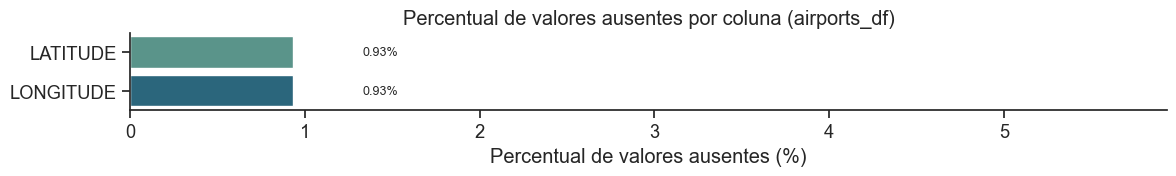

In [24]:
# Só colunas com >0% de nulos para visibilidade
plot_df = null_summary[null_summary["%_missing"] > 0].reset_index().rename(columns={"index":"coluna"})

if not plot_df.empty:
    fig, ax = plt.subplots(figsize=(12, 0.5 * max(4, len(plot_df))))
    sns.barplot(data=plot_df, x="%_missing", y="coluna", hue="coluna", palette="crest", dodge=False, ax=ax, legend=False)
    for i, v in enumerate(plot_df["%_missing"]):
        ax.text(v + 0.4, i, f"{v:.2f}%", va="center", fontsize=9)
    ax.set_xlabel("Percentual de valores ausentes (%)")
    ax.set_ylabel("")
    ax.set_xlim(0, plot_df["%_missing"].max() + 5)
    plt.title("")
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma coluna com valores ausentes.")

### Cardinalidade e Duplicatas

In [25]:
# Checagem de duplicidade pela chave natural
dup_iata = airports_df[airports_df.duplicated(subset=['IATA_CODE'], keep=False)]
print(f"Número de duplicatas pela chave IATA_CODE: {dup_iata.shape[0]}")

Número de duplicatas pela chave IATA_CODE: 0


In [26]:
# Verificação de duplicatas completas
dup_full = airports_df[airports_df.duplicated()]
print(f"Número de tuplas completamente duplicadas: {dup_full.shape[0]}")

Número de linhas completamente duplicadas: 0


In [27]:
# Verifica todas as colunas
for col in airports_df.columns:
    dup_count = airports_df.duplicated(subset=[col]).sum()
    print(f"{col}: {dup_count} duplicatas")

IATA_CODE: 0 duplicatas
AIRPORT: 0 duplicatas
CITY: 14 duplicatas
STATE: 268 duplicatas
COUNTRY: 321 duplicatas
LATITUDE: 2 duplicatas
LONGITUDE: 2 duplicatas


Os resultados mostram quase o esperado, nenhum valor duplicado no IATA_CODE e AIRPORT, e algumas duplicatas para as outras colunas. Porém, as colunas de coordenadas possuem 2 duplicatas e não 3 como esperado, isso pode ser justificado pelo fato do pandas tratar o 'NaN' como "valor" e os outros 'NaN' como repetição, mas vamos investigar melhor.

In [19]:
print(f"Tuplas com nuloss\n")
display(airports_df[airports_df[['LATITUDE', 'LONGITUDE']].isnull().any(axis=1)])
print(f"Tuplas com duplicatas nos nuloss\n")
display(airports_df[airports_df.duplicated(subset=['LATITUDE'])])

Tuplas com nuloss



,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. Augustine Airport),St. Augustine,FL,USA,NaN,NaN


Tuplas com duplicatas nos nuloss



,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. Augustine Airport),St. Augustine,FL,USA,NaN,NaN


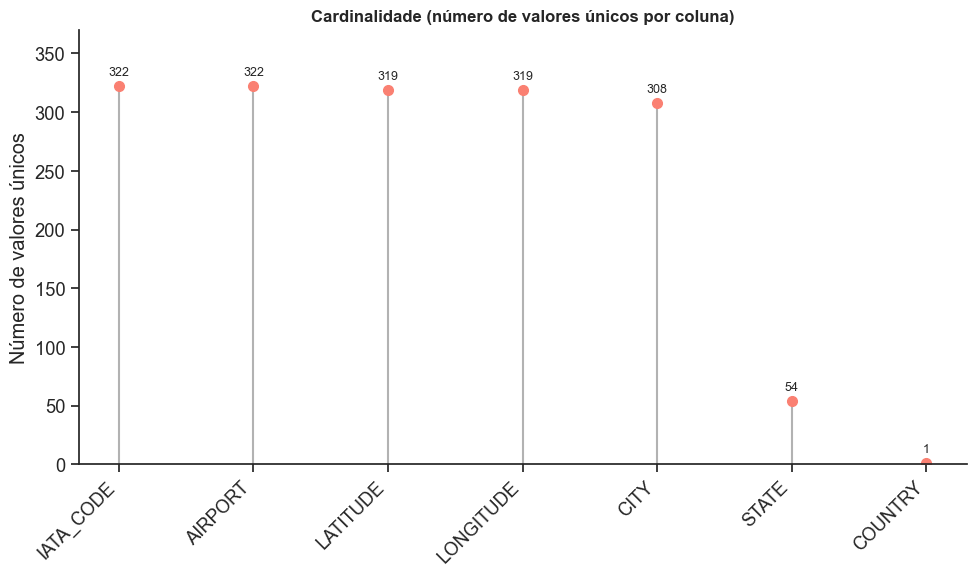

In [39]:
cardinality = (
    airports_df.nunique()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'index': 'coluna', 0: 'n_unique'})
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.vlines(
    x=cardinality["coluna"],
    ymin=0, ymax=cardinality["n_unique"],
    color="gray", alpha=0.6, linewidth=1.5
)
ax.plot(
    cardinality["coluna"], cardinality["n_unique"],
    "o", markersize=7, color="salmon"
)

for i, v in enumerate(cardinality["n_unique"]):
    ax.text(
        i, v + max(cardinality["n_unique"]) * 0.02,
        f"{v}", ha="center", va="bottom", fontsize=9
    )

# Estética e formatação
ax.set_title("Cardinalidade (número de valores únicos por coluna)", fontsize=12, weight="bold")
ax.set_ylabel("Número de valores únicos")
ax.set_xlabel("")
ax.set_ylim(0, cardinality["n_unique"].max() * 1.15)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Verificação de Tipos e Inconsistências

In [44]:
# Colunas que deveriam conter apenas texto
text_cols = ['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY']

for col in text_cols:
    non_text = airports_df[~airports_df[col].astype(str).str.match(r'^[A-Za-zÀ-ÿ\s\-\.\']+$', na=False)]
    
    if not non_text.empty:
        print(f"\nColuna '{col}' possui valores suspeitos (não textuais):")
        print(f"Total de tuplas afetadas: {len(non_text)}")
        display(non_text[col])
    else:
        print(f"\nColuna '{col}' sem valores suspeitos.")


✅ Coluna 'IATA_CODE' sem valores suspeitos.

⚠️ Coluna 'AIRPORT' possui valores suspeitos (não textuais):
→ Total de tuplas afetadas: 51


12                                             Augusta Regional Airport (Bush Field)
24                                       Wilkes-Barre/Scranton International Airport
25                                      Kalamazoo/Battle Creek International Airport
38                                                Boise Airport (Boise Air Terminal)
40                           Jack Brooks Regional Airport (Southeast Texas Regional)
44                              Brownsville/South Padre Island International Airport
50                                      Bob Hope Airport (Hollywood Burbank Airport)
52                Bozeman Yellowstone International Airport (Gallatin Field Airport)
56                                                  Merle K. (Mudhole) Smith Airport
57                                    Del Norte County Airport (Jack McNamara Field)
58                                   Chattanooga Metropolitan Airport (Lovell Field)
60                                   Charleston International Air


⚠️ Coluna 'CITY' possui valores suspeitos (não textuais):
→ Total de tuplas afetadas: 7


7                       Arcata/Eureka
24              Wilkes-Barre/Scranton
40               Beaumont/Port Arthur
68                   Champaign/Urbana
156           Iron Mountain/Kingsford
170                       Kailua/Kona
319    Fayetteville/Springdale/Rogers
Name: CITY, dtype: object

✅ Coluna 'STATE' sem valores suspeitos.
✅ Coluna 'COUNTRY' sem valores suspeitos.


### Plano de Ação - Diretrizes para a camada Silver

**Airline**
  - Realizar as conversões de tipos de acordo com as regras de negócio;
  - Alterar o nome da coluna IATA_CODE: *IATA_CODE* -> *AIRLINE_IATA_CODE*;
  - Tornar a coluna AIRLINE_IATA_CODE 'primary key'.

**Airports**
  - Realizar as conversões de tipos de acordo com as regras de negócio;
  - Alterar o nome da coluna IATA_CODE: *IATA_CODE* -> *AIRPORT_IATA_CODE*;
  - Tornar a coluna AIRPORT_IATA_CODE 'primary key'.
  - Remover coluna COUNTRY;
  - LATITUDE adicionar valores reais para as tuplas com IATA_CODE = ECP, PBG e UST;
  - LONGITUDE adicionar valores reais para as tuplas com IATA_CODE = ECP, PBG e UST.

**Flights**

## Análise do Dataset de Voos (flights.csv)

### Inspeção inicial

In [21]:
print("Dimensões (linhas, colunas):", flights_df.shape)

Dimensões (linhas, colunas): (5819079, 31)


In [23]:
display(flights_df.head())

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
flights_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [25]:
display(flights_df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
YEAR,5819079.0,NaN,NaN,NaN,2015.0,0.0,2015.0,2015.0,2015.0,2015.0,2015.0
MONTH,5819079.0,NaN,NaN,NaN,6.524085,3.405137,1.0,4.0,7.0,9.0,12.0
DAY,5819079.0,NaN,NaN,NaN,15.704594,8.783425,1.0,8.0,16.0,23.0,31.0
DAY_OF_WEEK,5819079.0,NaN,NaN,NaN,3.926941,1.988845,1.0,2.0,4.0,6.0,7.0
AIRLINE,5819079,14,WN,1261855,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLIGHT_NUMBER,5819079.0,NaN,NaN,NaN,2173.092742,1757.063999,1.0,730.0,1690.0,3230.0,9855.0
TAIL_NUMBER,5804358,4897,N480HA,3768,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORIGIN_AIRPORT,5819079,628,ATL,346836,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DESTINATION_AIRPORT,5819079,629,ATL,346904,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SCHEDULED_DEPARTURE,5819079.0,NaN,NaN,NaN,1329.60247,483.751821,1.0,917.0,1325.0,1730.0,2359.0


### Valores ausentes

In [26]:
null_counts = flights_df.isna().sum()
null_pct = (null_counts / len(flights_df) * 100).round(4)
null_summary = pd.concat([null_counts.rename("n_missing"), null_pct.rename("%_missing")], axis=1).sort_values("%_missing", ascending=False)
null_summary.head(30)

,n_missing,%_missing
CANCELLATION_REASON,5729195,98.4554
WEATHER_DELAY,4755640,81.7250
LATE_AIRCRAFT_DELAY,4755640,81.7250
AIRLINE_DELAY,4755640,81.7250
SECURITY_DELAY,4755640,81.7250
AIR_SYSTEM_DELAY,4755640,81.7250
AIR_TIME,105071,1.8056
ARRIVAL_DELAY,105071,1.8056
ELAPSED_TIME,105071,1.8056
WHEELS_ON,92513,1.5898


**Foram encontrados valores nulos. Gerando gráfico...**

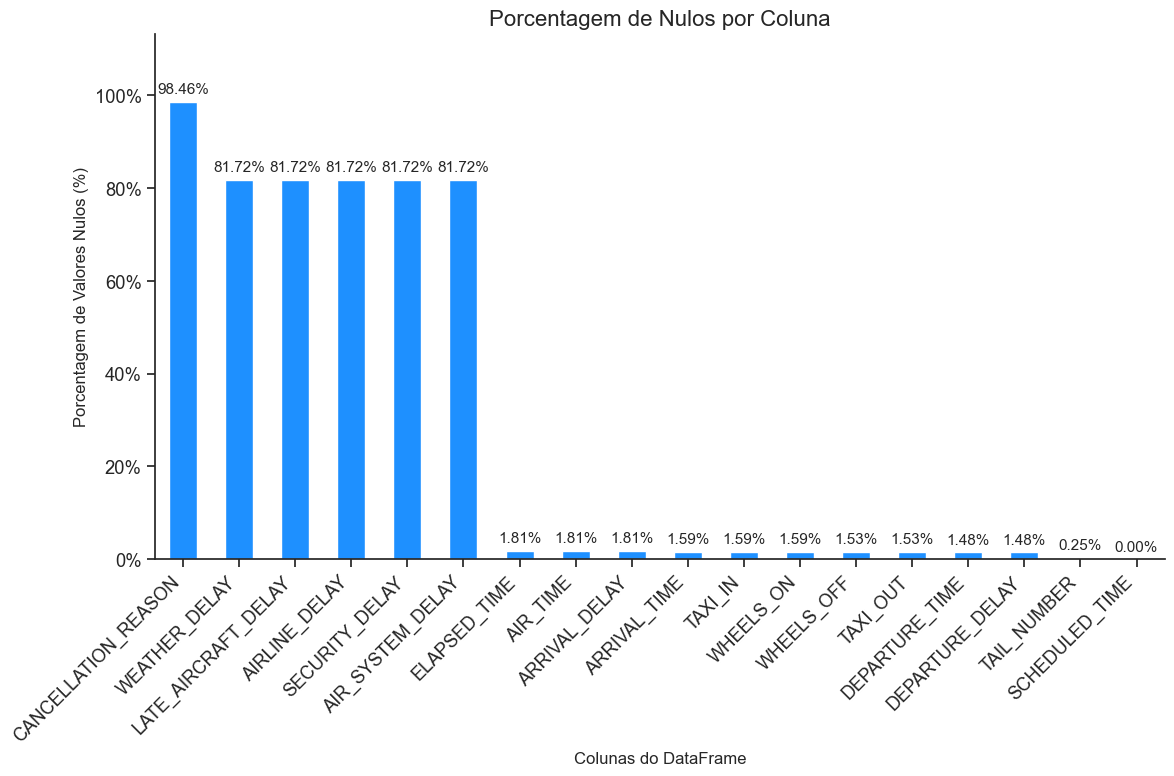

In [30]:
pctNulosFlight = (flights_df.isnull().sum() / len(flights_df)) * 100

pctNulosFlight = pctNulosFlight[pctNulosFlight > 0]

if not pctNulosFlight.empty:
  display(Markdown("**Foram encontrados valores nulos. Gerando gráfico...**"))
  pctNulosFlight = pctNulosFlight.sort_values(ascending=False)
  
  plt.figure(figsize=(12, 8))

  ax = pctNulosFlight.plot(kind='bar', color='dodgerblue')

  plt.title('Porcentagem de Nulos por Coluna', fontsize=16)
  plt.ylabel('Porcentagem de Valores Nulos (%)', fontsize=12)
  plt.xlabel('Colunas do DataFrame', fontsize=12)
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  
  ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
  for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=11)

  plt.ylim(0, pctNulosFlight.max() * 1.15)
  plt.show()
else:
  display(Markdown("**Não foram encontrados valores nulos no conjunto de dados.**"))

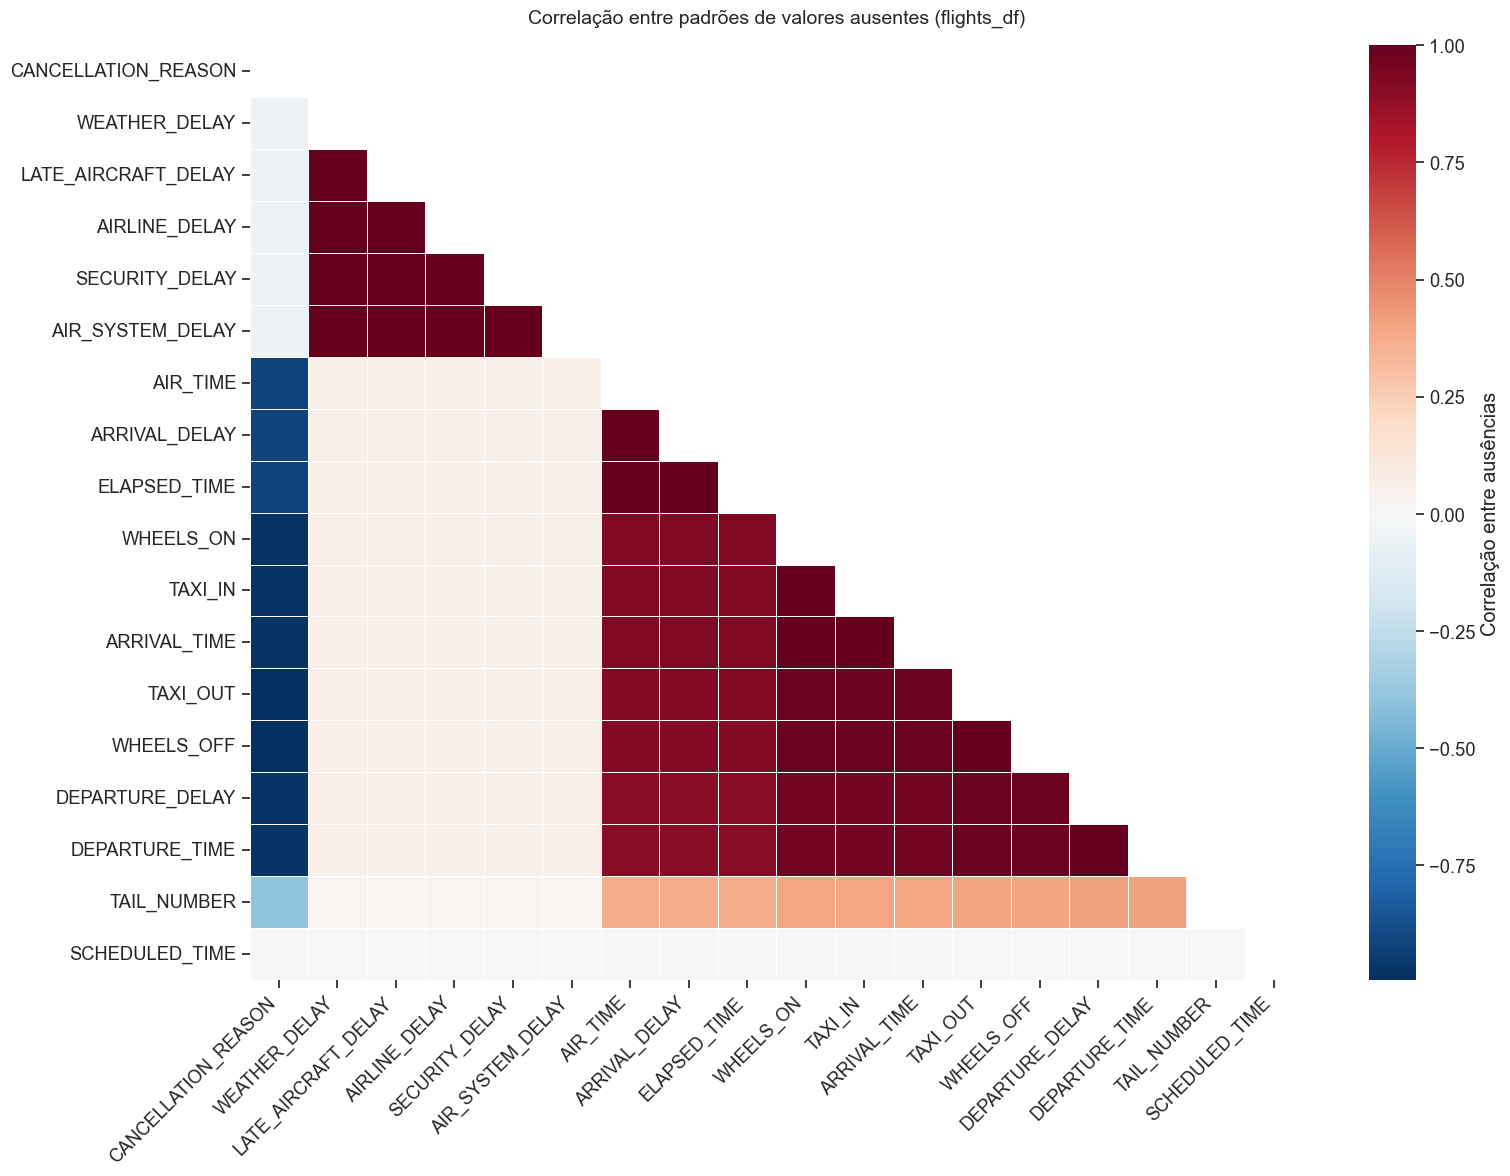

,coluna_1,coluna_2,corr
18,WEATHER_DELAY,LATE_AIRCRAFT_DELAY,1.0
89,AIR_SYSTEM_DELAY,SECURITY_DELAY,1.0
109,AIR_TIME,ELAPSED_TIME,1.0
125,ARRIVAL_DELAY,AIR_TIME,1.0
126,ARRIVAL_DELAY,ELAPSED_TIME,1.0
142,ELAPSED_TIME,AIR_TIME,1.0
143,ELAPSED_TIME,ARRIVAL_DELAY,1.0
162,WHEELS_ON,TAXI_IN,1.0
163,WHEELS_ON,ARRIVAL_TIME,1.0
19,WEATHER_DELAY,AIRLINE_DELAY,1.0


In [36]:
# Selecionar apenas colunas com missing > 0
cols_with_missing = null_summary[null_summary["n_missing"] > 0].index.tolist()

if cols_with_missing:
    miss_matrix = flights_df[cols_with_missing].isna().astype(int)
    corr = miss_matrix.corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(min(1.2*len(corr), 16), min(1.2*len(corr), 12)))
    sns.heatmap(
        corr,
        mask=mask,
        annot=False,
        cmap="RdBu_r",
        center=0,
        cbar_kws={'label': 'Correlação entre ausências'},
        linewidths=0.5
    )
    plt.title("Correlação entre padrões de valores ausentes", fontsize=14, pad=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    high_corr = (
        corr.where(~np.eye(len(corr), dtype=bool))
        .stack()
        .reset_index()
        .rename(columns={"level_0": "coluna_1", "level_1": "coluna_2", 0: "corr"})
        .query("corr > 0.85")
        .sort_values("corr", ascending=False)
    )
    display(high_corr.head(15))
else:
    print("Nenhuma coluna com valores ausentes.")


#### Investigando valores ausentes na CANCELLATION_REASON

In [15]:
flights_df[flights_df['CANCELLATION_REASON'].notnull()]['CANCELLATION_REASON'].sample(5)

1951509    A
934885     B
3920818    A
2981076    C
3236405    B
Name: CANCELLATION_REASON, dtype: object

In [14]:
cols = [
    'YEAR', 'MONTH', 'DAY', 'AIRLINE', 
    'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
    'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'CANCELLED', 'CANCELLATION_REASON'
]

samples_null = flights_df[flights_df['CANCELLATION_REASON'].isnull()].sample(n=5, random_state=42)
samples_not_null = flights_df[flights_df['CANCELLATION_REASON'].notnull()].sample(n=5, random_state=42)

temp_df = pd.concat([samples_null, samples_not_null])

temp_df[cols]

,YEAR,MONTH,DAY,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,ARRIVAL_DELAY,CANCELLED,CANCELLATION_REASON
3679572,2015,8,17,MQ,ABI,DFW,-6.0,-19.0,0,NaN
5202464,2015,11,21,DL,DTW,BWI,-1.0,25.0,0,NaN
381725,2015,1,26,DL,RDU,LAX,-5.0,-29.0,0,NaN
4296182,2015,9,25,UA,ORD,DSM,-3.0,-2.0,0,NaN
307995,2015,1,21,MQ,BTR,DFW,-8.0,-19.0,0,NaN
486834,2015,2,2,MQ,ORD,BNA,NaN,NaN,1,B
2739144,2015,6,22,UA,DFW,IAH,NaN,NaN,1,A
2897568,2015,7,1,WN,HOU,DAL,NaN,NaN,1,B
2453757,2015,6,5,B6,BOS,JFK,NaN,NaN,1,A
103455,2015,1,7,OO,SAN,BOI,-7.0,NaN,1,B


Os valores da 'CANCELLATION_REASON' são preenchidos, aparentemente, quando a coluna CANCELLED = 1, indicando que não há uma falha de preenchimento.

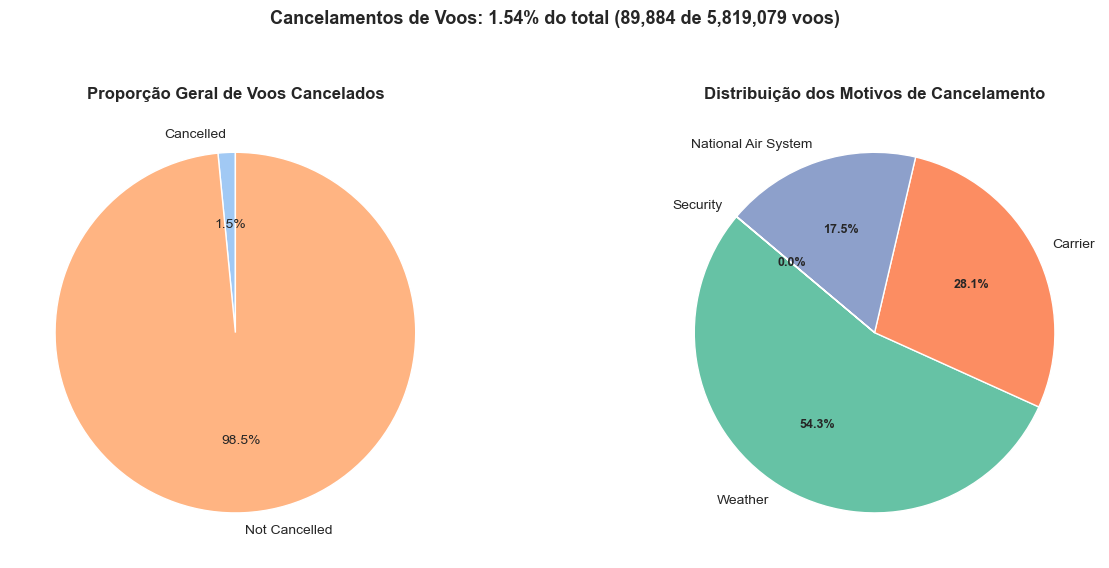

In [25]:
cancel_counts = (
    flights_df['CANCELLATION_REASON']
    .value_counts(dropna=False)
    .rename_axis('Reason')
    .reset_index(name='Count')
)

reason_labels = {
    'A': 'Carrier',
    'B': 'Weather',
    'C': 'National Air System',
    'D': 'Security',
    np.nan: 'Not Cancelled'
}
cancel_counts['Reason_Label'] = cancel_counts['Reason'].map(reason_labels)

cancel_only = cancel_counts[cancel_counts['Reason_Label'] != 'Not Cancelled']

total_flights = cancel_counts['Count'].sum()
total_cancelled = cancel_only['Count'].sum()
pct_cancelled = total_cancelled / total_flights * 100

fig, ax = plt.subplots(1, 2, figsize=(13, 6))

colors = sns.color_palette("pastel", 2)
ax[0].pie(
    [total_cancelled, total_flights - total_cancelled],
    labels=["Cancelled", "Not Cancelled"],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10}
)
ax[0].set_title("Proporção geral de voos cancelados", fontsize=12, weight='bold')

colors_cancel = sns.color_palette("Set2", len(cancel_only))
wedges, texts, autotexts = ax[1].pie(
    cancel_only['Count'],
    labels=cancel_only['Reason_Label'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors_cancel,
    textprops={'fontsize': 10}
)
plt.setp(autotexts, size=9, weight="bold")
ax[1].set_title("Distribuição dos motivos de cancelamento", fontsize=12, weight='bold')

plt.suptitle(
    "Cancelamentos de Voos",
    fontsize=13, weight='bold'
)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


A investigação mostra que os valores nulos em 'CANCELLATION_REASON' estão de acordo com as regras de negócio, pois a ausência deles mostra que os voos não foram cancelados.

#### Investigando valores ausentes nas colunas com final _DELAY

In [10]:
delay_cols = [c for c in flights_df.columns if c.endswith("_DELAY")]
delay_cols

# Contagem de nulos
delay_null_summary = flights_df[delay_cols].isna().sum().to_frame("n_missing")
delay_null_summary["pct_missing"] = (delay_null_summary["n_missing"] / len(flights_df) * 100).round(2)
display(delay_null_summary)

,n_missing,pct_missing
DEPARTURE_DELAY,86153,1.48
ARRIVAL_DELAY,105071,1.81
AIR_SYSTEM_DELAY,4755640,81.72
SECURITY_DELAY,4755640,81.72
AIRLINE_DELAY,4755640,81.72
LATE_AIRCRAFT_DELAY,4755640,81.72
WEATHER_DELAY,4755640,81.72


In [ ]:
# --- Gráfico de Regressão Linear: DEPARTURE_DELAY x ARRIVAL_DELAY ---
delay_df = flights_df[['DEPARTURE_DELAY', 'ARRIVAL_DELAY']].dropna()

fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(
    data=delay_df,
    x='DEPARTURE_DELAY',
    y='ARRIVAL_DELAY',
    line_kws={'color': 'red', 'lw': 2},
    scatter_kws={'alpha': 0.3, 's': 20}
)
ax.set_title("Relação entre Atraso na Partida e Atraso na Chegada", fontsize=13, weight='bold')
ax.set_xlabel("Atraso na Partida (minutos)")
ax.set_ylabel("Atraso na Chegada (minutos)")

# Calcula correlação e exibe no gráfico
corr_value = delay_df['DEPARTURE_DELAY'].corr(delay_df['ARRIVAL_DELAY'])
ax.text(0.05, 0.95, f"Correlação de Pearson: {corr_value:.2f}",
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle="round", fc="white", ec="gray"))
plt.tight_layout()
plt.show()


As colunas 'DEPARTURE_DELAY' e 'ARRIVAL_DELAY' apresentaram baixo percentual de valores ausentes (1,48% e 1,81%), enquanto as colunas relacionadas às causas de atraso (AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY) apresentaram cerca de 81,7% de nulos.

Esses nulos são esperados, pois esses campos só são preenchidos quando se há atraso muito significativos no voo. Tudo certo.

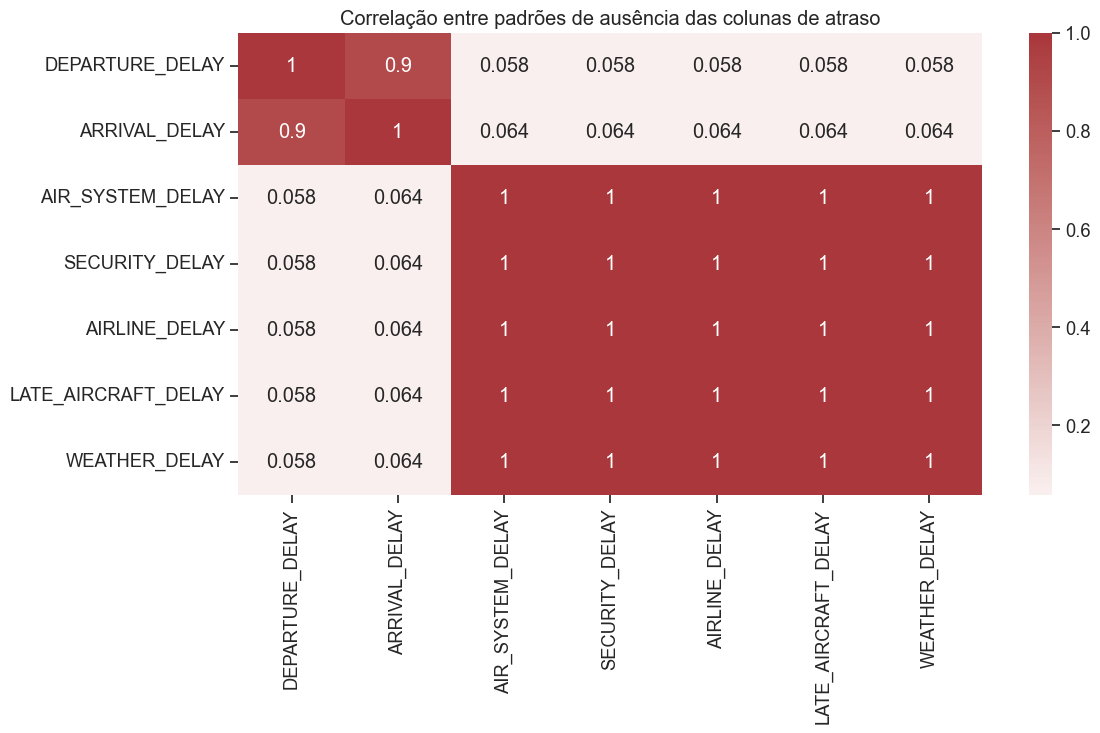

In [20]:
corr_delays = flights_df[delay_cols].isna().corr()
sns.heatmap(corr_delays, annot=True, cmap="vlag", center=0)
plt.title("Correlação entre padrões de ausência das colunas de atraso")
plt.show()

O mapa de correlação mostrou relação forte **(0,9)** entre os atrasos de partida e chegada, e correlação perfeita **(1,0)** entre as colunas de causas de atraso.
Isso indica que essas variáveis compartilham o mesmo padrão de preenchimento,as ausências ocorrem simultaneamente e não representam erro de coleta.

#### Investigando valores ausentes nas colunas com final _TIME e relacionadas

In [12]:
time_cols = [c for c in flights_df.columns if c.endswith("TIME")]

# Para cada uma, verificar a proporção de nulos com base em CANCELLED e DIVERTED
for col in time_cols:
    summary = (
        flights_df.groupby(["CANCELLED", "DIVERTED"])[col]
        .apply(lambda x: x.isna().mean() * 100)
        .reset_index(name="%_missing")
        .sort_values("%_missing", ascending=False)
    )
    print(f"\nPadrões de ausência para {col}:")
    display(summary)


Padrões de ausência para DEPARTURE_TIME:


,CANCELLED,DIVERTED,%_missing
2,1,0,95.849094
0,0,0,0.000000
1,0,1,0.000000



Padrões de ausência para SCHEDULED_TIME:


,CANCELLED,DIVERTED,%_missing
1,0,1,0.006585
2,1,0,0.005563
0,0,0,0.000000



Padrões de ausência para ELAPSED_TIME:


,CANCELLED,DIVERTED,%_missing
1,0,1,100.0
2,1,0,100.0
0,0,0,0.0



Padrões de ausência para AIR_TIME:


,CANCELLED,DIVERTED,%_missing
1,0,1,100.0
2,1,0,100.0
0,0,0,0.0



Padrões de ausência para ARRIVAL_TIME:


,CANCELLED,DIVERTED,%_missing
2,1,0,100.000000
1,0,1,17.310858
0,0,0,0.000000


Os dados mostram que os valores estão coerentes, os valores são nulos quando é um voo cancelado ou desviado. Voos desviados não têm seus registros de tempo preenchidos pelo USDOT, pois não são considerados voos completos. Mas vamos investigar para ver se é possível preencher.

In [17]:
cols = [
    'CANCELLED', 'DIVERTED', 'ELAPSED_TIME', 'AIR_TIME', 
    'TAXI_IN', 'TAXI_OUT',
]

flights_df[(flights_df['ELAPSED_TIME'].isnull()) & (flights_df['DIVERTED'] == 1)][cols].sample(10)

,CANCELLED,DIVERTED,ELAPSED_TIME,AIR_TIME,TAXI_IN,TAXI_OUT
2370765,0,1,NaN,NaN,6.0,10.0
4016146,0,1,NaN,NaN,4.0,7.0
2291668,0,1,NaN,NaN,4.0,9.0
2718969,0,1,NaN,NaN,NaN,13.0
3700520,0,1,NaN,NaN,7.0,13.0
3117682,0,1,NaN,NaN,5.0,34.0
2122069,0,1,NaN,NaN,6.0,2.0
2654408,0,1,NaN,NaN,17.0,17.0
2050347,0,1,NaN,NaN,13.0,13.0
5091206,0,1,NaN,NaN,6.0,11.0


In [13]:
cols = [
    'CANCELLED', 'DIVERTED', 'ELAPSED_TIME', 'AIR_TIME', 
    'WHEELS_OFF', 'WHEELS_ON',
]

flights_df[(flights_df['AIR_TIME'].isnull()) & (flights_df['DIVERTED'] == 1) & (flights_df['WHEELS_OFF'].isnull())][cols]

,CANCELLED,DIVERTED,ELAPSED_TIME,AIR_TIME,WHEELS_OFF,WHEELS_ON


In [8]:
# Filtra as linhas onde AIR_TIME é nulo
air_time_null_df = flights_df[flights_df['AIR_TIME'].isnull()]

# Conta quantos valores nulos existem nas colunas de interesse dentro desse filtro
null_counts = air_time_null_df[['WHEELS_ON', 'WHEELS_OFF']].isnull().sum()

print("Para os casos onde AIR_TIME é nulo:")
print(null_counts)

Para os casos onde AIR_TIME é nulo:
WHEELS_ON     92513
WHEELS_OFF    89047
dtype: int64


#### Investigando valores ausentes na coluna TAIL_NUMBER

In [19]:
flights_df[flights_df['TAIL_NUMBER'].isnull()]


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
297,2015,1,1,4,F9,865,NaN,MSO,DEN,600,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
298,2015,1,1,4,F9,1256,NaN,ORD,MIA,600,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
2216,2015,1,1,4,UA,641,NaN,LAX,HNL,845,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
3490,2015,1,1,4,UA,1412,NaN,ORD,PHL,1010,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
3763,2015,1,1,4,US,1883,NaN,SLC,PHL,1030,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5811608,2015,12,31,4,UA,598,NaN,SMF,DEN,1134,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
5813418,2015,12,31,4,UA,338,NaN,PDX,SFO,1339,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
5813861,2015,12,31,4,UA,1828,NaN,SEA,IAH,1405,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
5818090,2015,12,31,4,UA,1789,NaN,IAH,TPA,1955,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN


A coluna TAIL_NUMBER possui 14721 tuplas com valores nulos, este volume corresponde a apenas 0,25% do total de registros, sendo uma fração estatisticamente insignificante. Além disso, por se tratar de um identificador único, não é possível derivar seu valor igual a outras colunas e o esforço para se encontrar seus valores não supera os ganhos.

### Cardinalidade e duplicatas

In [5]:
# Duplicatas
dup_complete = flights_df.duplicated().sum()
print(f"Duplicatas completas: {dup_complete:,}")

Duplicatas completas: 0


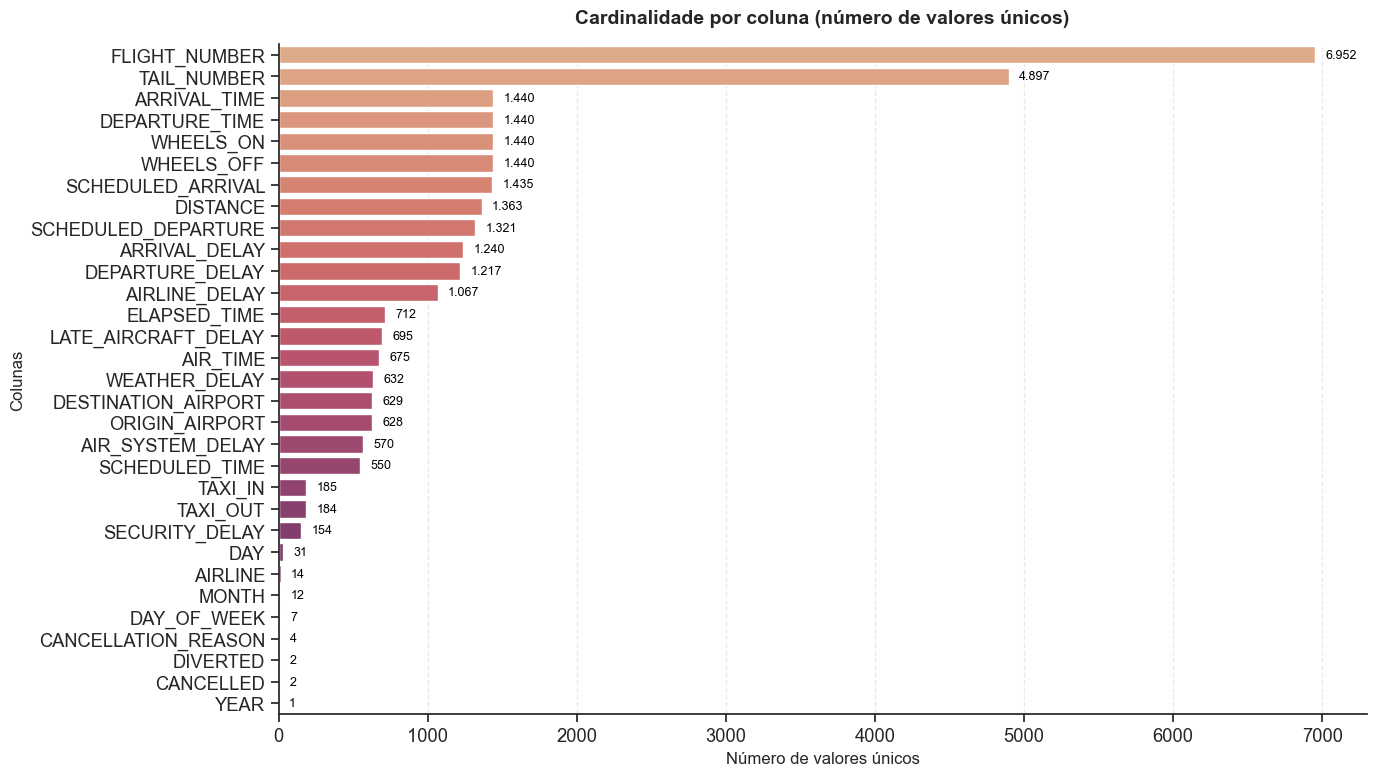

In [47]:
# Gráfico de duplicatas
cardinality = flights_df.nunique().sort_values(ascending=False).reset_index()
cardinality.columns = ["coluna", "n_valores_unicos"]

plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=cardinality,
    x="n_valores_unicos",
    y="coluna",
    hue="coluna",
    palette="flare",
    orient="h",
    legend=False
)

for i, v in enumerate(cardinality["n_valores_unicos"]):
    ax.text(
        v + (0.01 * cardinality["n_valores_unicos"].max()),
        i,
        f"{v:,}".replace(",", "."),
        va="center",
        fontsize=9,
        color="black"
    )

ax.set_title("Cardinalidade por coluna (número de valores únicos)", fontsize=14, weight="bold", pad=15)
ax.set_xlabel("Número de valores únicos", fontsize=12)
ax.set_ylabel("Colunas", fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [10]:
# Duplicatas com chave natural
key_cols = ["YEAR","MONTH","DAY","FLIGHT_NUMBER","AIRLINE"]
dup_counts = flights_df.groupby(key_cols).size().reset_index(name="count")
multi_keys = dup_counts[dup_counts['count'] > 1]
print(f"Chaves naturais com múltiplos registros: {len(multi_keys):,}")

subset = flights_df.merge(multi_keys[key_cols], on=key_cols, how="inner")
all_identical = (subset.groupby(key_cols).nunique(dropna=False) == 1).all(axis=1).all()
print(f"Todos os registros das chaves naturais são 100% idênticos em todas as colunas? {all_identical}")

Chaves naturais com múltiplos registros: 1,310,079
Todos os registros das chaves naturais são 100% idênticos em todas as colunas? False


In [26]:
# Pegando 5 chaves naturais para inspeção
multi_keys = flights_df.groupby(key_cols).size().reset_index(name="count").query("count>1").sort_values("count", ascending=False).head(5)
multi_keys

if not multi_keys.empty:
    example = multi_keys.iloc[0][key_cols].to_dict()
    mask = pd.concat([flights_df[c] == example[c] for c in key_cols], axis=1).all(axis=1)
    display(flights_df.loc[mask].sort_values(["ORIGIN_AIRPORT","SCHEDULED_DEPARTURE"]))
else:
    print("Nenhuma chave natural com repetições encontrada.")


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
1638494,2015,4,15,3,WN,891,N665WN,AUS,ELP,1405,...,1440.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1631557,2015,4,15,3,WN,891,N665WN,DAL,TUL,715,...,816.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1634601,2015,4,15,3,WN,891,N665WN,DEN,AUS,1015,...,1320.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1639412,2015,4,15,3,WN,891,N665WN,ELP,LAX,1505,...,1617.0,7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1642876,2015,4,15,3,WN,891,N665WN,LAS,SEA,1830,...,2127.0,17.0,0,0,NaN,3.0,0.0,6.0,8.0,0.0
1641130,2015,4,15,3,WN,891,N665WN,LAX,LAS,1650,...,1758.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1645528,2015,4,15,3,WN,891,N665WN,SEA,OAK,2150,...,2344.0,-6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1633087,2015,4,15,3,WN,891,N665WN,TUL,DEN,845,...,913.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Observando as duplicatas naturais, percebe-se que o motivo de está duplicado é porque as tuplas representam voos de escalas, que apesar de terem o mesmo número de voos são viagens diferentes.

### Verificação de tipos e inconsistências

Alguns tipos de dados devem ser modificados, nas colunas de tempos o formato não está ideal para a visualização (valor inteiro, ex: 0000) o ideal seria datetime. As colunas contendo datas devem ser agregadas em uma única coluna. Outras inconsistências já foram verificadas.

### Plano de Ação - Diretrizes para a camada Silver

**Airline**
  - Realizar as conversões de tipos de acordo com as regras de negócio;
  - Alterar o nome da coluna IATA_CODE: *IATA_CODE* -> *AIRLINE_IATA_CODE*;
  - Tornar a coluna AIRLINE_IATA_CODE 'primary key'.

**Airports**
  - Realizar as conversões de tipos de acordo com as regras de negócio;
  - Alterar o nome da coluna IATA_CODE: *IATA_CODE* -> *AIRPORT_IATA_CODE*;
  - Tornar a coluna AIRPORT_IATA_CODE 'primary key'.
  - Remover coluna COUNTRY;
  - LATITUDE adicionar valores reais para as tuplas com IATA_CODE = ECP, PBG e UST;
  - LONGITUDE adicionar valores reais para as tuplas com IATA_CODE = ECP, PBG e UST.

**Flights**
  - Realizar as conversões de tipos de acordo com as regras de negócio;
  - Adicionar nova coluna para ser primary key;
  - Alterar a códificação da coluna CANCELLATION_REASON para nomes reais: 'A': 'Carrier', 'B': 'Weather', 'C': 'National Air System', 'D': 'Security';
  - Remover as tuplas que possuem valores nulos na coluna TAIL_NUMBER;
  - Agregar as colunas de data (YEAR, MONTH, DAY e DAY_OF_WEEK) em uma única coluna de data DATE;
  - Altera as colunas de tempo para o formato datetime, atualmente os dois primeiros dígitos são as horas e os dois últimos os minutos;
  - Recalcular os tempos derivados (AIR_TIME e ELAPSED_TIME) apenas quando todas as colunas auxiliares estiverem completas;
  - Manter AIR_TIME e ELAPSED_TIME nulos em voos cancelados, evitando imputações artificiais.
